# CYBERBULLYING – MiniLM Embeddings + Clustering (Confidence-Aware)
#

# 0 Mount google drive

In [1]:
# =========================
# SETUP CELL
# =========================
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=False)

BASE_DIR = "/content/drive/MyDrive/grunitech-project3-cyberbullying"
DATA_DIR = f"{BASE_DIR}/data"
PROCESSED_DIR = f"{DATA_DIR}/processed"

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("✅ Drive mounted")
print("BASE_DIR:", BASE_DIR)


Mounted at /content/drive
✅ Drive mounted
BASE_DIR: /content/drive/MyDrive/grunitech-project3-cyberbullying


# 1 Setup

In [2]:
!pip install sentence-transformers datasets scikit-learn umap-learn plotly pandas
!pip install evaluate
!pip install transformers==4.57.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


## 1.a. Imports

In [3]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import umap
import plotly.express as px


# 2 Load messages (with confidence)

In [4]:
CONF_PATH = f"{PROCESSED_DIR}/messages_with_confidence.parquet"

df = pd.read_parquet(CONF_PATH)

print("Loaded rows:", len(df))
df.head()


texts = df["cleaned_text"].tolist()
labels = df["label"].values
confidences = df["bullying_confidence"].values

print("Texts:", len(texts))
print("Mean confidence:", confidences.mean())


Loaded rows: 34020
Texts: 34020
Mean confidence: 0.5493659054306114


# 3 Load MiniLM encoder

In [5]:
encoder = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2"
)

print("MiniLM loaded")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

MiniLM loaded


# 4 Generate embeddings

In [6]:
embeddings = encoder.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Embeddings shape:", embeddings.shape)


Batches:   0%|          | 0/532 [00:00<?, ?it/s]

Embeddings shape: (34020, 384)



# 5 Save embeddings

In [7]:
np.save(f"{PROCESSED_DIR}/minilm_embeddings.npy", embeddings)
np.save(f"{PROCESSED_DIR}/labels.npy", labels)
np.save(f"{PROCESSED_DIR}/confidences.npy", confidences)

print("✅ Embeddings + metadata saved")


✅ Embeddings + metadata saved


# 6 Quick clustering (sanity check)

In [8]:
k = 2  # bully / non-bully rough split
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

sil = silhouette_score(embeddings, clusters)
print("Silhouette score:", round(sil, 3))


Silhouette score: 0.032


# 7 Inspect clusters using confidence

In [9]:
for cid in range(k):
    idx = clusters == cid
    print(
        f"Cluster {cid}: "
        f"size={idx.sum()}, "
        f"mean_conf={confidences[idx].mean():.3f}, "
        f"true_bully_rate={labels[idx].mean():.3f}"
    )


Cluster 0: size=16240, mean_conf=0.584, true_bully_rate=0.537
Cluster 1: size=17780, mean_conf=0.518, true_bully_rate=0.466


# 8 Visualize clusters

In [10]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

points = reducer.fit_transform(embeddings)

fig = px.scatter(
    x=points[:, 0],
    y=points[:, 1],
    color=confidences,
    title="MiniLM embedding space colored by bullying confidence",
    labels={"color": "bullying_confidence"}
)

fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



# 9 Build masks for later cluster modeling

In [11]:
STRONG_BULLY = confidences > 0.9
STRONG_SAFE  = confidences < 0.1
AMBIGUOUS    = ~(STRONG_BULLY | STRONG_SAFE)

print("Strong bully samples:", STRONG_BULLY.sum())
print("Strong safe samples:", STRONG_SAFE.sum())
print("Ambiguous samples:", AMBIGUOUS.sum())


Strong bully samples: 10619
Strong safe samples: 5669
Ambiguous samples: 17732


# 10 Save index masks (for cluster sampling later)

In [12]:
np.save(f"{PROCESSED_DIR}/strong_bully_idx.npy", STRONG_BULLY)
np.save(f"{PROCESSED_DIR}/strong_safe_idx.npy", STRONG_SAFE)
np.save(f"{PROCESSED_DIR}/ambiguous_idx.npy", AMBIGUOUS)

print("✅ Index masks saved")


✅ Index masks saved


# 11 Inspect confidence distribution

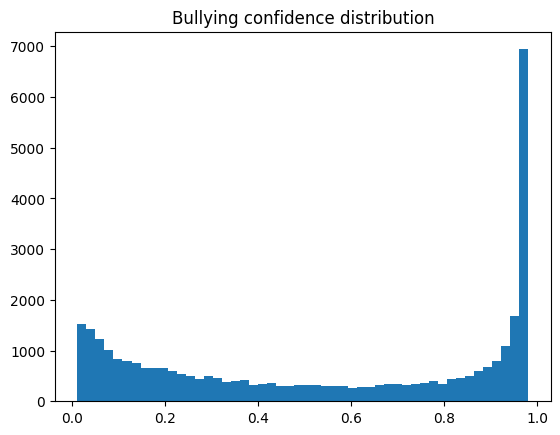

Top 1% confidence mean: 0.9793110402448436
Bottom 1% confidence mean: 0.015325534829318173


In [14]:
import matplotlib.pyplot as plt

plt.hist(confidences, bins=50)
plt.title("Bullying confidence distribution")
plt.show()


print("Top 1% confidence mean:", confidences[confidences > np.percentile(confidences, 99)].mean())
print("Bottom 1% confidence mean:", confidences[confidences < np.percentile(confidences, 1)].mean())
